## Basic Caption Cookbook
This notebook demonstrates how to use the captioning API to generate captions for images with guided outputs.

In [25]:
import os
import httpx
from typing import Union
from PIL import Image
import io

client = httpx.Client(timeout=60.0)
from PIL import Image, ImageDraw, ImageFont
from odr_caption.outlines.vision import load_image, load_img_from_url


def generate_caption(image_path: Union[str, os.PathLike]):
    # Load and resize image
    if image_path.startswith(('http://', 'https://')):
        response = httpx.get(image_path)
        image = Image.open(io.BytesIO(response.content))
    else:
        image = Image.open(image_path)
    
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()

    files = {"file": ("image.png", img_byte_arr, "image/png")}
    response = client.post("http://localhost:32100/generate_caption", files=files)
    
    if response.status_code == 200:
        caption_data = response.json()["content"]
    else:
        raise Exception(f"Error: {response.status_code}, {response.text}")
    
    generate_report(image, caption_data)
    
    return caption_data

"""Report gen stuff for this notebook, not needed for captioning"""
def generate_report(image, caption_data):
    # resize for notebook display
    max_size = 512
    ratio = max_size / max(image.size)
    new_size = tuple([int(x*ratio) for x in image.size])
    image = image.resize(new_size, Image.LANCZOS)
    
    # Determine report dimensions
    image_width, image_height = image.size
    text_width = 500  # Approximate width needed for text
    report_width = min(1024, image_width + text_width + 20)  # Add some padding
    report_height = max(512, image_height)
    
    # Create the report image
    report = Image.new('RGB', (report_width, report_height), color='white')
    
    # Paste the resized image
    report.paste(image, (0, 0))
    
    # Add caption information
    draw = ImageDraw.Draw(report)
    title_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 14)
    body_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 12)
    
    text_start_x = image_width + 10  # Start text right after the image
    text_start_y = 10
    line_height = 18
    
    # Short Caption
    draw.text((text_start_x, text_start_y), "Short Caption:", fill='black', font=title_font)
    draw.text((text_start_x, text_start_y + line_height), caption_data['short_caption'], fill='black', font=body_font)
    
    # Dense Caption
    draw.text((text_start_x, text_start_y + 3*line_height), "Dense Caption:", fill='black', font=title_font)
    wrapped_dense_caption = wrap_text(caption_data['dense_caption'], body_font, report_width - text_start_x - 10)
    for i, line in enumerate(wrapped_dense_caption):
        draw.text((text_start_x, text_start_y + (4+i)*line_height), line, fill='black', font=body_font)
    
    # Tags
    draw.text((text_start_x, text_start_y + 13*line_height), "Tags:", fill='black', font=title_font)
    for i, tag in enumerate(caption_data['tags_list']):
        tag_text = f"{tag['tag']} ({tag['category']}, {tag['confidence']:.2f})"
        draw.text((text_start_x, text_start_y + (14+i)*line_height), tag_text, fill='black', font=body_font)
    
    # Display the report
    display(report)

def wrap_text(text, font, max_width):
    words = text.split()
    lines = []
    current_line = []
    for word in words:
        test_line = ' '.join(current_line + [word])
        bbox = font.getbbox(test_line)
        if bbox[2] <= max_width:
            current_line.append(word)
        else:
            lines.append(' '.join(current_line))
            current_line = [word]
    lines.append(' '.join(current_line))
    return lines




## Examples


URL image report:


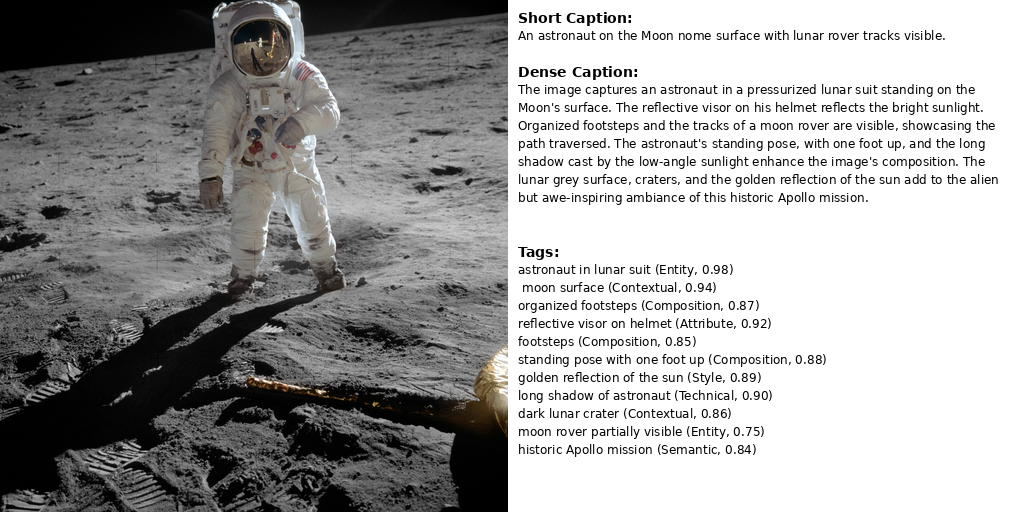

{'tags_list': [{'tag': 'astronaut in lunar suit',
   'category': 'Entity',
   'confidence': 0.98},
  {'tag': ' moon surface', 'category': 'Contextual', 'confidence': 0.94},
  {'tag': 'organized footsteps',
   'category': 'Composition',
   'confidence': 0.87},
  {'tag': 'reflective visor on helmet',
   'category': 'Attribute',
   'confidence': 0.92},
  {'tag': 'footsteps', 'category': 'Composition', 'confidence': 0.85},
  {'tag': 'standing pose with one foot up',
   'category': 'Composition',
   'confidence': 0.88},
  {'tag': 'golden reflection of the sun',
   'category': 'Style',
   'confidence': 0.89},
  {'tag': 'long shadow of astronaut',
   'category': 'Technical',
   'confidence': 0.9},
  {'tag': 'dark lunar crater', 'category': 'Contextual', 'confidence': 0.86},
  {'tag': 'moon rover partially visible',
   'category': 'Entity',
   'confidence': 0.75},
  {'tag': 'historic Apollo mission',
   'category': 'Semantic',
   'confidence': 0.84}],
 'short_caption': 'An astronaut on the Moo

In [26]:
url_image_path = "https://upload.wikimedia.org/wikipedia/commons/9/98/Aldrin_Apollo_11_original.jpg"
print("\nURL image report:")
caption_data = generate_caption(url_image_path)
display(caption_data)

In [27]:
# We can also read in the object into the Schema for ease of use further in the pipeline if needed 
from odr_caption.schemas.caption import ImageData
image_data = ImageData(**caption_data)
print("Dense Caption: ", image_data.dense_caption)
print("Short Caption: ", image_data.short_caption)
print("Tags: ")
for tag in image_data.tags_list:
      print(tag)



Dense Caption:  The image captures an astronaut in a pressurized lunar suit standing on the Moon's surface. The reflective visor on his helmet reflects the bright sunlight. Organized footsteps and the tracks of a moon rover are visible, showcasing the path traversed. The astronaut's standing pose, with one foot up, and the long shadow cast by the low-angle sunlight enhance the image's composition. The lunar grey surface, craters, and the golden reflection of the sun add to the alien but awe-inspiring ambiance of this historic Apollo mission.
Short Caption:  An astronaut on the Moon nome surface with lunar rover tracks visible.
Tags: 
tag='astronaut in lunar suit' category=<TagType.ENTITY: 'Entity'> confidence=0.98
tag=' moon surface' category=<TagType.CONTEXTUAL: 'Contextual'> confidence=0.94
tag='organized footsteps' category=<TagType.COMPOSITION: 'Composition'> confidence=0.87
tag='reflective visor on helmet' category=<TagType.ATTRIBUTE: 'Attribute'> confidence=0.92
tag='footsteps' c

## Additional Examples


URL image report:


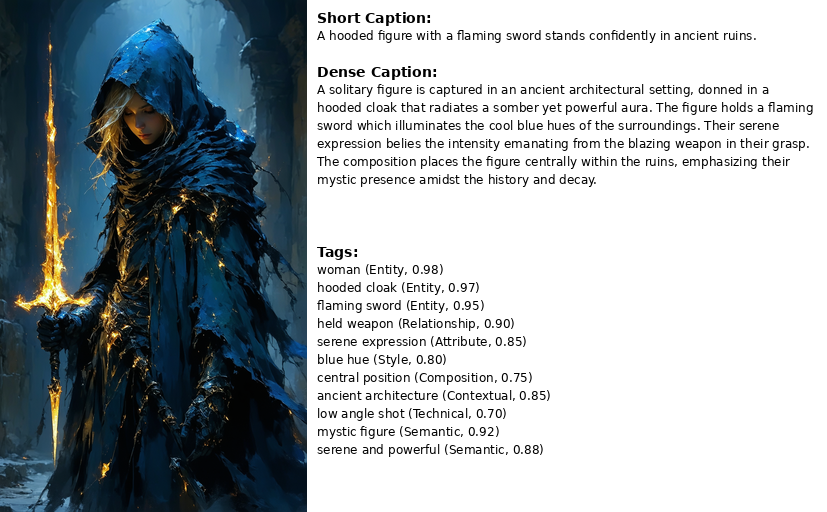

{'tags_list': [{'tag': 'woman', 'category': 'Entity', 'confidence': 0.98},
  {'tag': 'hooded cloak', 'category': 'Entity', 'confidence': 0.97},
  {'tag': 'flaming sword', 'category': 'Entity', 'confidence': 0.95},
  {'tag': 'held weapon', 'category': 'Relationship', 'confidence': 0.9},
  {'tag': 'serene expression', 'category': 'Attribute', 'confidence': 0.85},
  {'tag': 'blue hue', 'category': 'Style', 'confidence': 0.8},
  {'tag': 'central position', 'category': 'Composition', 'confidence': 0.75},
  {'tag': 'ancient architecture',
   'category': 'Contextual',
   'confidence': 0.85},
  {'tag': 'low angle shot', 'category': 'Technical', 'confidence': 0.7},
  {'tag': 'mystic figure', 'category': 'Semantic', 'confidence': 0.92},
  {'tag': 'serene and powerful', 'category': 'Semantic', 'confidence': 0.88}],
 'short_caption': 'A hooded figure with a flaming sword stands confidently in ancient ruins.',
 'dense_caption': 'A solitary figure is captured in an ancient architectural setting, don

In [28]:
url_image_path = "https://image.civitai.com/xG1nkqKTMzGDvpLrqFT7WA/00300e2b-bc02-4e26-96ac-506b4bce95ea/original=true,quality=90/35990960.jpeg"
print("\nURL image report:")
caption_data = generate_caption(url_image_path)
display(caption_data)


URL image report:


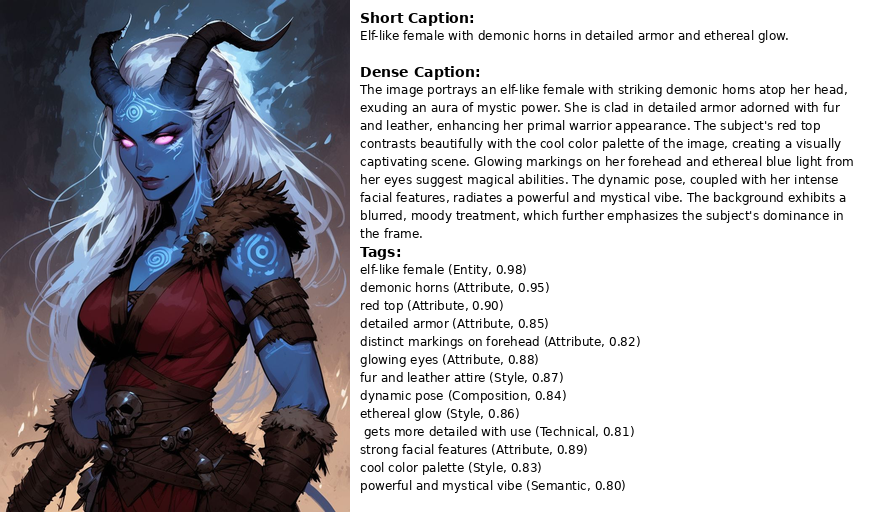

{'tags_list': [{'tag': 'elf-like female',
   'category': 'Entity',
   'confidence': 0.98},
  {'tag': 'demonic horns', 'category': 'Attribute', 'confidence': 0.95},
  {'tag': 'red top', 'category': 'Attribute', 'confidence': 0.9},
  {'tag': 'detailed armor', 'category': 'Attribute', 'confidence': 0.85},
  {'tag': 'distinct markings on forehead',
   'category': 'Attribute',
   'confidence': 0.82},
  {'tag': 'glowing eyes', 'category': 'Attribute', 'confidence': 0.88},
  {'tag': 'fur and leather attire', 'category': 'Style', 'confidence': 0.87},
  {'tag': 'dynamic pose', 'category': 'Composition', 'confidence': 0.84},
  {'tag': 'ethereal glow', 'category': 'Style', 'confidence': 0.86},
  {'tag': ' gets more detailed with use',
   'category': 'Technical',
   'confidence': 0.81},
  {'tag': 'strong facial features',
   'category': 'Attribute',
   'confidence': 0.89},
  {'tag': 'cool color palette', 'category': 'Style', 'confidence': 0.83},
  {'tag': 'powerful and mystical vibe',
   'category

In [29]:
url_image_path = "https://image.civitai.com/xG1nkqKTMzGDvpLrqFT7WA/81f8e626-a822-4815-b8be-361ff65b0d88/original=true,quality=90/16382509.jpeg"
print("\nURL image report:")
caption_data = generate_caption(url_image_path)
display(caption_data)